# Temporal analysis

The analysis attempts to determine if players are influenced by the moment they played; by the main topic of the moment.


- Extraction of date of each path OK
- Extraction the link subject in each path OK
- Regroup these 2 points to know which are the most used subjects according to a period (by year)
- Statistical analysis 

In [10]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.contrib import tzip
from spicy import stats
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [11]:
#path
DATA_PATH = "data/wikispeedia_paths-and-graph/"

In [12]:
df_finished_paths = pd.read_csv(DATA_PATH + "paths_finished.tsv", sep="\t", header = None, skiprows=15, names = [
    'hashedIpAddress',   'timestamp',   'durationInSec',   'path',   'rating',
  ])
df_unfinished_paths = pd.read_csv(DATA_PATH + "paths_unfinished.tsv", sep="\t", header = None, skiprows=16, names = [
    'hashedIpAddress',   'timestamp',   'durationInSec',   'path',   'target'   ,'type'
  ])
# create dataframe with all path
all_paths = pd.concat([df_finished_paths.iloc[:, :4], df_unfinished_paths.iloc[:, :4]], ignore_index=True)
# sorted by temporal order
all_paths.sort_values(by="timestamp", inplace=True)


### Extraction of date of each path

In [13]:
# extract datetime of the path year/ month/ day and hour
all_paths["timestamp"] = [datetime.fromtimestamp(x).strftime("%m,%d,%Y,%I:%M:%S") for x in all_paths["timestamp"]]
all_paths["year"] = [x.split(",")[2] for x in all_paths["timestamp"]]
all_paths["month"] = [x.split(",")[0] for x in all_paths["timestamp"]]
all_paths["day"] = [x.split(",")[1] for x in all_paths["timestamp"]]
all_paths["hour"] = [x.split(",")[3] for x in all_paths["timestamp"]]
all_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,year,month,day,hour
15545,NaN,"08,18,2008,11:29:32",106,Tropical_Storm_Bonnie_%282004%29;Gulf_of_Mexic...,2008,08,18,11:29:32
13719,NaN,"08,18,2008,11:29:32",140,Tyrannosaurus;London;Temperate;Weather;Solar_S...,2008,08,18,11:29:32
10377,NaN,"08,18,2008,11:29:32",96,Heat;Latin;Europe;Italy,2008,08,18,11:29:32
4869,321e4b101c5b58ff,"08,19,2008,12:39:45",91,George_W._Bush;Jesus;Christianity;Roman_Cathol...,2008,08,19,12:39:45
2510,321e4b101c5b58ff,"08,19,2008,12:48:15",81,Brazil;Agriculture;Ethanol;Hydrogen;Chemical_e...,2008,08,19,12:48:15


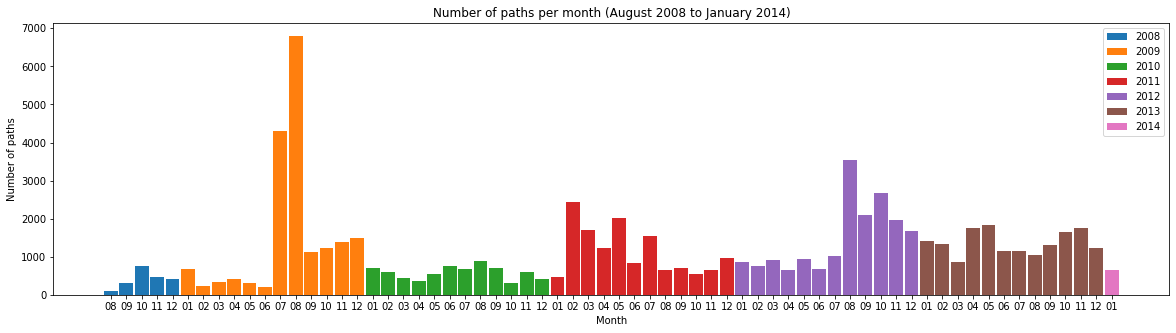

In [14]:
# barplot of the number of path in each month
# groupe by year and month and count
freq_timestamp = all_paths.groupby(["year", "month"], as_index=False).size().reset_index()

# barplot
fig, ax= plt.subplots(1, 1, figsize = (20, 5))
year_color = {"2008": 'lightcoral', "2009": 'lightsalmon', "2010": 'bisque', 
              "2011": 'palegreen', "2012": 'skyblue', "2013": 'lightpink', "2014": 'silver'}
start = 0
for year, color in year_color.items():
    value = freq_timestamp.loc[freq_timestamp["year"] == year]
    b = plt.bar(x = np.arange(start, start + len(value)), height = value["size"], width = 0.9)
    start = start + len(value)
ax.set_xticks(np.arange(66))
ax.set_xticklabels(freq_timestamp["month"])
year_color = {"2008": 'lightcoral', "2009": 'lightsalmon', "2010": 'bisque', 
              "2011": 'palegreen', "2012": 'skyblue', "2013": 'lightpink', "2014": 'silver'}
ax.legend(year_color.keys())
ax.set_title("Number of paths per month (August 2008 to January 2014)")
ax.set_xlabel("Month")
a = ax.set_ylabel("Number of paths")
fig.savefig('img/time_distribution.jpg', format='jpg')

We can see on the bar plot the temporal distribution of path between August 2008 and January 2014. <br\>
There is a peak in Jully and August 2009. <br\>
Less path in 2010 than in other year. <br\>

### Extraction the link subject in each path OK

In [15]:
# find all categories in each path
''' link_categories = pd.read_csv(DATA_PATH + "categories.tsv", sep="\t", header = None, skiprows=13, names = [
    'article',   'categories'
  ])
different_categories = link_categories["categories"].unique()
cat_dataframe = pd.DataFrame(0, index=all_paths.index, columns=different_categories)
for index, path in tzip(all_paths.index, all_paths["path"]):
    path_split = path.split(";")
    for link in path_split:
        if link != "<":
            link_row = link_categories.loc[link_categories["article"] == link]
            for cat in link_row["categories"]:
                cat_dataframe.loc[index][cat] = cat_dataframe.loc[index][cat] + 1      
cat_dataframe.to_pickle("cat_dataframe.pkl") '''

# just load the dataframe saved in a pickle format (beacause long to create ~ 15 minutes)
cat_dataframe = pd.read_pickle("data/cat_dataframe.pkl")
# a row: index of the path and nb of link with the follwing subject in the path (0 if not)
cat_dataframe.head()

,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,subject.People.Historical_figures,subject.Countries,subject.Geography.European_Geography.European_Countries,subject.People.Artists,subject.Business_Studies.Currency,subject.History.General_history,subject.History.Military_History_and_War,subject.Science.Physics.Space_Astronomy,subject.Everyday_life.Sports_events,...,subject.History.British_History,subject.IT.Cryptography,subject.Citizenship.Law,subject.History.North_American_History,subject.Citizenship.Culture_and_Diversity,subject.Citizenship.Education,subject.Science.Biology.Evolution_and_reproduction,subject.Science.Chemistry.Materials_science,subject.Science.Physics.The_Planets,subject.Art.Artists
15545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13719,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
10377,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2510,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Regroup these 2 points to know which are the most used subjects according to a period (by year)

In [16]:
# add the number of cat by year
cat_dataframe["nb_cat"] = cat_dataframe.sum(axis=1)

# count each occurrence of the topic by grouping it by year to be able to find the most popular topics in each year.
all_paths = pd.concat([all_paths, cat_dataframe], join = 'outer', axis = 1)

In [17]:
# calculate number of page visited by year
nb_cat_by_year = all_paths.groupby(["year"]).sum()["nb_cat"]

# number of time click on cat by year
cat_by_year = all_paths.groupby(["year"]).sum()
cat_by_year = cat_by_year.drop(columns = "durationInSec")
cat_by_year = cat_by_year.div(nb_cat_by_year, axis=0) #normalize
cat_by_year = cat_by_year.drop(columns = "nb_cat")
# a row: for each year, the number of occurrences of each subject in a path.
cat_by_year.head(20)

C:\Users\Emilien\AppData\Local\Temp/ipykernel_16512/2403508253.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nb_cat_by_year = all_paths.groupby(["year"]).sum()["nb_cat"]
C:\Users\Emilien\AppData\Local\Temp/ipykernel_16512/2403508253.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cat_by_year = all_paths.groupby(["year"]).sum()


,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,subject.People.Historical_figures,subject.Countries,subject.Geography.European_Geography.European_Countries,subject.People.Artists,subject.Business_Studies.Currency,subject.History.General_history,subject.History.Military_History_and_War,subject.Science.Physics.Space_Astronomy,subject.Everyday_life.Sports_events,...,subject.History.British_History,subject.IT.Cryptography,subject.Citizenship.Law,subject.History.North_American_History,subject.Citizenship.Culture_and_Diversity,subject.Citizenship.Education,subject.Science.Biology.Evolution_and_reproduction,subject.Science.Chemistry.Materials_science,subject.Science.Physics.The_Planets,subject.Art.Artists
year,,,,,,,,,,,,,,,,,,,,,
2008,0.003270,0.005030,0.120480,0.039552,0.002327,0.001761,0.013142,0.004968,0.017292,0.001635,...,0.005722,0.000189,0.003396,0.001509,0.002704,0.002578,0.003144,0.003081,0.012765,0.0
2009,0.008876,0.005607,0.112185,0.039657,0.001862,0.003152,0.019125,0.007821,0.016346,0.002752,...,0.005083,0.000448,0.003062,0.001248,0.003166,0.003117,0.003366,0.002138,0.010214,0.0
2010,0.008631,0.004935,0.112224,0.040661,0.001904,0.003623,0.016782,0.008871,0.018113,0.002865,...,0.005064,0.000296,0.002384,0.001294,0.003549,0.003493,0.003327,0.001589,0.011773,0.0
2011,0.011391,0.004517,0.109466,0.039496,0.001624,0.002746,0.021220,0.007273,0.022467,0.002567,...,0.005061,0.000377,0.003049,0.001174,0.003793,0.002578,0.002798,0.001645,0.012166,0.0
2012,0.008532,0.003909,0.105172,0.037876,0.001567,0.002274,0.018316,0.005637,0.019432,0.003040,...,0.005245,0.000298,0.003534,0.001039,0.003227,0.002759,0.003125,0.001456,0.012850,0.0
2013,0.009693,0.004532,0.105510,0.038669,0.001528,0.002812,0.020164,0.006995,0.020068,0.002742,...,0.005091,0.000367,0.002681,0.001249,0.003659,0.002934,0.002934,0.001773,0.012200,0.0
2014,0.009698,0.006234,0.109905,0.039945,0.001847,0.003002,0.017086,0.006927,0.024244,0.003002,...,0.004387,0.000231,0.002309,0.000231,0.002540,0.004618,0.002540,0.000693,0.015932,0.0


# remove 2008 and 2014 t-test paired

In [18]:
cat_by_year_2 = cat_by_year.drop(index=["2008", "2014"])
cat_signif_2 = {"2009": [], "2010": [], "2011": [], "2012": [], "2013": []}

# iterate on all categories
for cat, proba in cat_by_year_2.items():
    #perform anova test
    if proba.nunique() != 1:
        for year in ["2009", "2010", "2011", "2012", "2013"]:
            group1 = [proba[year] for i in range(4)]
            group2 = []
            for year2 in ["2009", "2010", "2011", "2012", "2013"]:
                if year2 != year:       
                    group2.append(proba[year2]) 
            stat, p = stats.ttest_rel(group1, group2)
            if p < 0.001:
                cat_signif_2[year].append(cat)
cat_signif_2

{'2009': ['subject.People.USA_Presidents', 'subject.Geography.Mineralogy'],
 '2010': [],
 '2011': [],
 '2012': ['subject.Design_and_Technology.Road_transport',
  'subject.Science.Biology.Organisms',
  'subject.Everyday_life.Cartoons',
  'subject.History.British_History'],
 '2013': ['subject.Everyday_life.Sports', 'subject.Everyday_life.Television']}

# analysing 2011 and 2013 with decisions forest

In [19]:
path_2011_2013 = all_paths.loc[(all_paths["year"]=="2011") | (all_paths["year"]=="2013")]

# target 1 if 2011 0 if 2013
y= [1 if i=="2011" else 0 for i in path_2011_2013["year"]]

# dataset of categories used in path
X = path_2011_2013.drop(columns=["hashedIpAddress", "timestamp", "durationInSec", "path", "year", "month", "day", "hour"]) # drop unused columns
X = X.drop(columns = [i for i in X.columns if X[i].sum()==0])


# split into train an test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
# create random forest model
forest = RandomForestClassifier()
# fit model to train data
forest.fit(X_train,y_train)
# predict on the test set
predictions = forest.predict(X_test)
# compute precision
accuraccy = metrics.accuracy_score(y_test, predictions)
print(f"Accuraccy score: {accuraccy}")


Accuraccy score: 0.5384996695307337
